# Time Series Analysis of July 2006 Heat Wave

This notebook processes and makes plots of the temporal evolution of meteorology during the course of the July 2006 heat wave in the western U.S.

In [61]:
# Start by importing required packages and information about your operating system:
import os 
import datetime

import pandas as pd
import matplotlib.pyplot as plt

from glob import glob


## Set the Directory Structure

In [41]:
# Identify the top-level data input and output directories:
data_input_dir =  '/Volumes/LaCie/wrf_to_tell/wrf_tell_counties_output'
data_output_dir =  '/Users/burl878/Documents/code_repos/ntp_heat_wave/data'
image_output_dir =  '/Users/burl878/Documents/code_repos/ntp_heat_wave/plots'

# If the "data_output_dir" subdirectory doesn't exist then create it:
if not os.path.exists(data_output_dir):
   os.makedirs(data_output_dir)

# If the "image_output_dir" subdirectory doesn't exist then create it:
if not os.path.exists(image_output_dir):
   os.makedirs(image_output_dir)


## Process the Population-Weighted Time Series:

In [3]:
# Define a function to convert from Kelvin to Fahrenheit:
def kelvin_to_farenheight(temperature_K: int):
    temperature_F = (1.8*(temperature_K - 273) + 32).round(2)
    return temperature_F


In [40]:
# Define function to process the population-weighted time series for a given year and scenario:
def process_met_time_series(data_input_dir: str, data_output_dir: str, year_to_process: int, scenario_to_process: str):
    # Read in the historical population file:
    pop_df = pd.read_csv(os.path.join(data_output_dir, 'county_populations_2000_to_2020.csv'))
    
    # Rename some columns:
    pop_df.rename(columns={'pop_2006': 'Population','state_name': 'State', 'county_name': 'County', 'county_FIPS': 'FIPS'}, inplace=True)
    
    # Only keep the columns that are needed:
    pop_df = pop_df[['State', 'County', 'FIPS', 'Population']].copy()
    
    # Set the data input directory:
    met_data_dir = os.path.join(data_input_dir, scenario_to_process, str(year_to_process))

    # Initiate an empty dataframe and counter to store the results:
    output_df = pd.DataFrame()
    
    # Create a list of all county meteorology files in the input directory:
    list_of_files = glob(f'{met_data_dir}/*.csv')
    
    # Loop over that list and extract the population-weighted T2 values:
    for file in range(len(list_of_files)):
        # Extract the file name from the list:
        filename = list_of_files[file].rsplit('/', 1)[1]
       
        # Extract the time string from the name of the file:
        file_time = filename.replace("_UTC_County_Mean_Meteorology.csv", "")

        # Read in the .csv file:
        met_df = pd.read_csv(os.path.join(met_data_dir, filename))

        # Only keep the columns that are needed:
        met_df = met_df[['FIPS', 'T2']].copy()
    
        # Merge the dataframes based on county FIPS code :
        df_combined = pd.merge(met_df, pop_df, how='left', on=['FIPS'])
    
        # Subset to only counties in the WECC:
        wecc_df = df_combined.loc[df_combined['State'].isin(['Washington', 'Oregon', 'California', 'Montana', 'Idaho', 'Nevada', 'Arizona', 'New Mexico', 'Colorado', 'Utah', 'Wyoming'])].copy()
    
        # Calculate the total population in the WECC:
        wecc_total_population = wecc_df['Population'].sum()
    
        # Calculate the fraction of the total population that lives in each county:
        wecc_df['Population_Fraction'] = wecc_df['Population'] / wecc_total_population
    
        # Calculate population-weighted mean temperature in the WECC:
        wecc_mean_temperature = (wecc_df['T2'] * wecc_df['Population_Fraction']).sum().round(2)
    
        # Subset to only counties in California:
        ca_df = df_combined.loc[df_combined['State'].isin(['California'])].copy()
    
        # Calculate the total population in the California:
        ca_total_population = ca_df['Population'].sum()
    
        # Calculate the fraction of the total population that lives in each county:
        ca_df['Population_Fraction'] = ca_df['Population'] / ca_total_population
    
        # Calculate population-weighted mean temperature in the California:
        ca_mean_temperature = (ca_df['T2'] * ca_df['Population_Fraction']).sum().round(2)
    
        # Calculate the total population in the U.S.:
        us_total_population = df_combined['Population'].sum()
    
        # Calculate the fraction of the total population that lives in each county:
        df_combined['Population_Fraction'] = df_combined['Population'] / us_total_population
    
        # Calculate population-weighted mean temperature in the U.S.:
        us_mean_temperature = (df_combined['T2'] * df_combined['Population_Fraction']).sum().round(2)
    
        # Subset to only Los Angeles county:
        la_df = df_combined.loc[df_combined['FIPS'] == 6037].copy()
    
        # Extract the temperature value for Los Angeles county:
        la_mean_temperature = la_df['T2'].sum().round(2)
    
        # Store the results
        output_df.loc[file, 'Time_UTC'] = pd.to_datetime(file_time, exact=False, format='%Y_%m_%d_%H')
        output_df.loc[file, 'US_T2_F'] = kelvin_to_farenheight(us_mean_temperature)
        output_df.loc[file, 'WECC_T2_F'] = kelvin_to_farenheight(wecc_mean_temperature)
        output_df.loc[file, 'CA_T2_F'] = kelvin_to_farenheight(ca_mean_temperature)
        output_df.loc[file, 'LA_T2_F'] = kelvin_to_farenheight(la_mean_temperature)
        
        # Clear up the old dataframes and move to the next step in the loop:
        del filename, file_time, met_df, df_combined, wecc_df, wecc_total_population, ca_df, ca_total_population, ca_mean_temperature, us_total_population, us_mean_temperature, la_df, la_mean_temperature
    
    # Set the output filename:
    csv_output_filename = os.path.join(data_output_dir + '/' + str(year_to_process) + '_Time_Series_' + scenario_to_process + '.csv')

    # Write out the dataframe to a .csv file:
    output_df.to_csv(csv_output_filename, sep=',', index=False)
    
    return output_df


In [ ]:
# Process the time series for that scenario:
output_df = process_met_time_series(data_input_dir = data_input_dir,
                                    data_output_dir = data_output_dir,
                                    year_to_process = 2086, 
                                    scenario_to_process = 'rcp85hotter')

output_df


In [149]:
# Define a function to plot time series of population-weighted temperature for the heat wave event:
def plot_temperature_time_series(start_day: int, end_day: int, ymin: int, ymax: int, data_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Read in the input files:
    df_2006 = pd.read_csv((data_input_dir + '/' + '2006_Time_Series_historic.csv'), parse_dates=["Time_UTC"])
    df_2046_rcp45cooler = pd.read_csv((data_input_dir + '/' + '2046_Time_Series_rcp45cooler.csv'), parse_dates=['Time_UTC'])
    df_2046_rcp45hotter = pd.read_csv((data_input_dir + '/' + '2046_Time_Series_rcp45hotter.csv'), parse_dates=['Time_UTC'])
    df_2046_rcp85cooler = pd.read_csv((data_input_dir + '/' + '2046_Time_Series_rcp85cooler.csv'), parse_dates=['Time_UTC'])
    df_2046_rcp85hotter = pd.read_csv((data_input_dir + '/' + '2046_Time_Series_rcp85hotter.csv'), parse_dates=['Time_UTC'])
    df_2086_rcp45cooler = pd.read_csv((data_input_dir + '/' + '2086_Time_Series_rcp45cooler.csv'), parse_dates=['Time_UTC'])
    df_2086_rcp45hotter = pd.read_csv((data_input_dir + '/' + '2086_Time_Series_rcp45hotter.csv'), parse_dates=['Time_UTC'])
    df_2086_rcp85cooler = pd.read_csv((data_input_dir + '/' + '2086_Time_Series_rcp85cooler.csv'), parse_dates=['Time_UTC'])
    df_2086_rcp85hotter = pd.read_csv((data_input_dir + '/' + '2086_Time_Series_rcp85hotter.csv'), parse_dates=['Time_UTC'])
    
    # Make the plot:
    plt.figure(figsize=(25, 10))
        
    plt.subplot(3,3,1)
    plt.plot(df_2006['Time_UTC'], df_2006['WECC_T2_F'], color='black', linestyle='-', label='2006', linewidth=2)
    plt.xlim([datetime.date(2006, 7, start_day), datetime.date(2006, 7, end_day)])
    plt.ylim([ymin, ymax])
    plt.xticks([])
    plt.legend(loc='lower left')
    plt.xlabel('')
    plt.ylabel('Mean Temperature [F]')
    plt.title('Temperature in the WECC: 2006')
    
    plt.subplot(3,3,2)
    plt.plot(df_2046_rcp45cooler['Time_UTC'], df_2046_rcp45cooler['WECC_T2_F'], color='b', linestyle='-', label='rcp45cooler', linewidth=1)
    plt.plot(df_2046_rcp45hotter['Time_UTC'], df_2046_rcp45hotter['WECC_T2_F'], color='g', linestyle='-', label='rcp45hotter', linewidth=1)
    plt.plot(df_2046_rcp85cooler['Time_UTC'], df_2046_rcp85cooler['WECC_T2_F'], color='orange', linestyle='-', label='rcp85cooler', linewidth=1)
    plt.plot(df_2046_rcp85hotter['Time_UTC'], df_2046_rcp85hotter['WECC_T2_F'], color='r', linestyle='-', label='rcp85hotter', linewidth=1)
    plt.xlim([datetime.date(2046, 7, start_day), datetime.date(2046, 7, end_day)])
    plt.ylim([ymin, ymax])
    plt.xticks([])
    plt.legend(loc='lower left', mode='expand', ncol=4)
    plt.xlabel('')
    plt.ylabel('Mean Temperature [F]')
    plt.title('Temperature in the WECC: 2046')
    
    plt.subplot(3,3,3)
    plt.plot(df_2086_rcp45cooler['Time_UTC'], df_2086_rcp45cooler['WECC_T2_F'], color='b', linestyle='-', label='rcp45cooler', linewidth=1)
    plt.plot(df_2086_rcp45hotter['Time_UTC'], df_2086_rcp45hotter['WECC_T2_F'], color='g', linestyle='-', label='rcp45hotter', linewidth=1)
    plt.plot(df_2086_rcp85cooler['Time_UTC'], df_2086_rcp85cooler['WECC_T2_F'], color='orange', linestyle='-', label='rcp85cooler', linewidth=1)
    plt.plot(df_2086_rcp85hotter['Time_UTC'], df_2086_rcp85hotter['WECC_T2_F'], color='r', linestyle='-', label='rcp85hotter', linewidth=1)
    plt.xlim([datetime.date(2086, 7, start_day), datetime.date(2086, 7, end_day)])
    plt.ylim([ymin, ymax])
    plt.xticks([])
    plt.legend(loc='lower left', mode='expand', ncol=4)
    plt.xlabel('')
    plt.ylabel('Mean Temperature [F]')
    plt.title('Temperature in the WECC: 2086')
    
    plt.subplot(3,3,4)
    plt.plot(df_2006['Time_UTC'], df_2006['CA_T2_F'], color='black', linestyle='-', label='2006', linewidth=2)
    plt.xlim([datetime.date(2006, 7, start_day), datetime.date(2006, 7, end_day)])
    plt.ylim([ymin, ymax])
    plt.xticks([])
    plt.legend(loc='lower left')
    plt.xlabel('')
    plt.ylabel('Mean Temperature [F]')
    plt.title('Temperature in California: 2006')
    
    plt.subplot(3,3,5)
    plt.plot(df_2046_rcp45cooler['Time_UTC'], df_2046_rcp45cooler['CA_T2_F'], color='b', linestyle='-', label='rcp45cooler', linewidth=1)
    plt.plot(df_2046_rcp45hotter['Time_UTC'], df_2046_rcp45hotter['CA_T2_F'], color='g', linestyle='-', label='rcp45hotter', linewidth=1)
    plt.plot(df_2046_rcp85cooler['Time_UTC'], df_2046_rcp85cooler['CA_T2_F'], color='orange', linestyle='-', label='rcp85cooler', linewidth=1)
    plt.plot(df_2046_rcp85hotter['Time_UTC'], df_2046_rcp85hotter['CA_T2_F'], color='r', linestyle='-', label='rcp85hotter', linewidth=1)
    plt.xlim([datetime.date(2046, 7, start_day), datetime.date(2046, 7, end_day)])
    plt.ylim([ymin, ymax])
    plt.xticks([])
    plt.legend(loc='lower left', mode='expand', ncol=4)
    plt.xlabel('')
    plt.ylabel('Mean Temperature [F]')
    plt.title('Temperature in California: 2046')
    
    plt.subplot(3,3,6)
    plt.plot(df_2086_rcp45cooler['Time_UTC'], df_2086_rcp45cooler['CA_T2_F'], color='b', linestyle='-', label='rcp45cooler', linewidth=1)
    plt.plot(df_2086_rcp45hotter['Time_UTC'], df_2086_rcp45hotter['CA_T2_F'], color='g', linestyle='-', label='rcp45hotter', linewidth=1)
    plt.plot(df_2086_rcp85cooler['Time_UTC'], df_2086_rcp85cooler['CA_T2_F'], color='orange', linestyle='-', label='rcp85cooler', linewidth=1)
    plt.plot(df_2086_rcp85hotter['Time_UTC'], df_2086_rcp85hotter['CA_T2_F'], color='r', linestyle='-', label='rcp85hotter', linewidth=1)
    plt.xlim([datetime.date(2086, 7, start_day), datetime.date(2086, 7, end_day)])
    plt.ylim([ymin, ymax])
    plt.xticks([])
    plt.legend(loc='lower left', mode='expand', ncol=4)
    plt.xlabel('')
    plt.ylabel('Mean Temperature [F]')
    plt.title('Temperature in California: 2086')
    
    plt.subplot(3,3,7)
    plt.plot(df_2006['Time_UTC'], df_2006['LA_T2_F'], color='black', linestyle='-', label='2006', linewidth=2)
    plt.xlim([datetime.date(2006, 7, start_day), datetime.date(2006, 7, end_day)])
    plt.ylim([ymin, ymax])
    plt.legend(loc='lower left')
    plt.xlabel('Time [UTC]')
    plt.ylabel('Mean Temperature [F]')
    plt.title('Temperature in Los Angeles County: 2006')
    
    plt.subplot(3,3,8)
    plt.plot(df_2046_rcp45cooler['Time_UTC'], df_2046_rcp45cooler['LA_T2_F'], color='b', linestyle='-', label='rcp45cooler', linewidth=1)
    plt.plot(df_2046_rcp45hotter['Time_UTC'], df_2046_rcp45hotter['LA_T2_F'], color='g', linestyle='-', label='rcp45hotter', linewidth=1)
    plt.plot(df_2046_rcp85cooler['Time_UTC'], df_2046_rcp85cooler['LA_T2_F'], color='orange', linestyle='-', label='rcp85cooler', linewidth=1)
    plt.plot(df_2046_rcp85hotter['Time_UTC'], df_2046_rcp85hotter['LA_T2_F'], color='r', linestyle='-', label='rcp85hotter', linewidth=1)
    plt.xlim([datetime.date(2046, 7, start_day), datetime.date(2046, 7, end_day)])
    plt.ylim([ymin, ymax])
    plt.legend(loc='lower left', mode='expand', ncol=4)
    plt.xlabel('Time [UTC]')
    plt.ylabel('Mean Temperature [F]')
    plt.title('Temperature in Los Angeles County: 2046')
    
    plt.subplot(3,3,9)
    plt.plot(df_2086_rcp45cooler['Time_UTC'], df_2086_rcp45cooler['LA_T2_F'], color='b', linestyle='-', label='rcp45cooler', linewidth=1)
    plt.plot(df_2086_rcp45hotter['Time_UTC'], df_2086_rcp45hotter['LA_T2_F'], color='g', linestyle='-', label='rcp45hotter', linewidth=1)
    plt.plot(df_2086_rcp85cooler['Time_UTC'], df_2086_rcp85cooler['LA_T2_F'], color='orange', linestyle='-', label='rcp85cooler', linewidth=1)
    plt.plot(df_2086_rcp85hotter['Time_UTC'], df_2086_rcp85hotter['LA_T2_F'], color='r', linestyle='-', label='rcp85hotter', linewidth=1)
    plt.xlim([datetime.date(2086, 7, start_day), datetime.date(2086, 7, end_day)])
    plt.ylim([ymin, ymax])
    plt.legend(loc='lower left', mode='expand', ncol=4)
    plt.xlabel('Time [UTC]')
    plt.ylabel('Mean Temperature [F]')
    plt.title('Temperature in Los Angeles County: 2086')
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = ('Heat_Wave_Temperature_Time_Series.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')


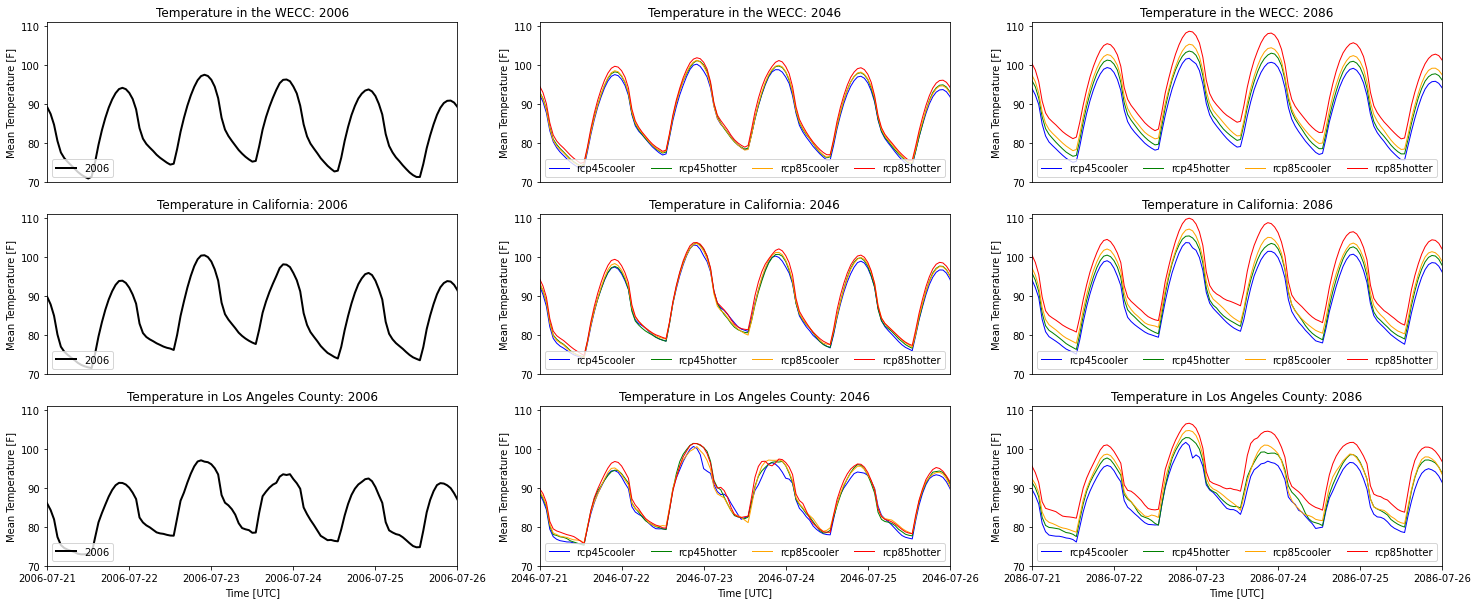

In [154]:
plot_temperature_time_series(start_day = 21,
                             end_day = 26,
                             ymin = 70, 
                             ymax = 111, 
                             data_input_dir = data_output_dir,
                             image_output_dir = image_output_dir, 
                             image_resolution = 125, 
                             save_images = True)
